# Predicting Real Estate Value using supervised Machine Learning

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score, ConfusionMatrixDisplay, f1_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import set_config
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler, FunctionTransformer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, RFECV, SelectFromModel

In [2]:
housing_raw = pd.read_csv("data/housing_iteration_5_classification/housing_iteration_5_classification.csv")

## Explore Dataset

In [3]:
housing_raw.sample(20)

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,Expensive,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
163,5500,55.0,882,1,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,Y,NaN,MnPrv,NaN,WD,Normal
1100,8400,60.0,290,1,0,0,1,0,0,0,...,Detchd,Unf,TA,TA,N,NaN,NaN,NaN,WD,Normal
490,2665,NaN,264,3,1,0,1,141,0,0,...,BuiltIn,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal
714,13517,NaN,725,3,0,0,2,0,0,0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
101,9206,77.0,741,3,1,0,2,192,0,0,...,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal
623,2117,NaN,756,2,1,0,2,0,0,0,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal
501,9803,75.0,866,3,0,0,2,0,0,0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
126,4928,NaN,1078,2,1,0,2,0,0,0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1306,6955,48.0,1368,2,1,0,2,132,0,0,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,New,Partial
620,8248,45.0,864,2,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,WD,Normal


In [4]:
housing_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotArea        1460 non-null   int64  
 1   LotFrontage    1201 non-null   float64
 2   TotalBsmtSF    1460 non-null   int64  
 3   BedroomAbvGr   1460 non-null   int64  
 4   Fireplaces     1460 non-null   int64  
 5   PoolArea       1460 non-null   int64  
 6   GarageCars     1460 non-null   int64  
 7   WoodDeckSF     1460 non-null   int64  
 8   ScreenPorch    1460 non-null   int64  
 9   Expensive      1460 non-null   int64  
 10  MSZoning       1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Heating        1460 non-null   object 
 13  Street         1460 non-null   object 
 14  CentralAir     1460 non-null   object 
 15  Foundation     1460 non-null   object 
 16  ExterQual      1460 non-null   object 
 17  ExterCond      1460 non-null   object 
 18  BsmtQual

#### Notes:
- There are 81 columns
- feature description: see [housing_iteration_5_classification.txt](data/housing_iteration_5_classification/housing_iteration_5_classification.txt)
- categorical data will preprocessed:
    - manually order ordinal data, where it makes sense. 
    - one-hot-encode the other categorical columns
    - missing values will be treated bei inserting "N_A" 
- For numeric columns, missing data will be imputes susing SinmpleImputer. Scaling is performed by varying Scalers (see superparameters) 
- date-features (e.g., YearBuilt) come in year-only format and dtype int - should be fine, when scaled.  

## Prepare data

In [3]:
# Define y and X
y = housing_raw["Expensive"]
X = housing_raw.drop(["Expensive", "Id"], axis=1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31416)

In [ ]:
# Define ordinal categories
ExterQual_cat = ["N_A","Po", "Fa", "TA", "Gd", "Ex"]
ExterCond_cat = ["N_A","Po", "Fa", "TA", "Gd", "Ex"]
BsmtQual_cat = ["N_A","Po", "Fa", "TA", "Gd", "Ex"]  # use the N_A string we later introduce as a custom string to replace missing values
BsmtCond_cat = ["N_A","Po", "Fa", "TA", "Gd", "Ex"]
BsmtExposure_cat = ["N_A", "No", "Mn", "Av", "Gd"]
BsmtFinType1_cat = ["N_A", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"]
KitchenQual_cat = ["N_A","Po", "Fa", "TA", "Gd", "Ex"]
FireplaceQu_cat = ["N_A","Po", "Fa", "TA", "Gd", "Ex"]
LotShape_cat = ["N_A","Reg", "IR1", "IR2", "IR3"]
Utilities_cat = ["N_A","ELO", "NoSeWa", "NoSewr", "AllPub"]
LandSlope_cat = ["N_A","Sev", "Mod", "Gtl"]
BsmtFinType2_cat = ["N_A", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"]
HeatingQC_cat = ["N_A","Po", "Fa", "TA", "Gd", "Ex"]
Functional_cat = ["N_A","Typ", "Min1", "Min2", "Mod", "Maj1", "Maj2", "Sev", "Sal"]
GarageFinish_cat = ["N_A", "Unf", "RFn", "Fin"]
GarageQual_cat = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
GarageCond_cat = ["N_A", "Po", "Fa", "TA", "Gd", "Ex"]
PoolQC_cat = ["N_A", "Fa", "TA", "Gd", "Ex"]
Fence_cat = ["N_A", "MnWw", "GdWo", "MnPrv", "GdPrv"]


# select categorical and numerical column names
X_cat_columns = ["MSZoning", "Condition1", "Heating", "Street", "CentralAir", "Foundation", "MasVnrType", 
                 "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition2", "BldgType",
                 "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType",
                 "Electrical", "GarageType", "PavedDrive", "MiscFeature", "SaleType", "SaleCondition"]
X_ord_columns = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", 
                 "KitchenQual", "FireplaceQu", "LotShape", "Utilities", "LandSlope", "BsmtFinType2", 
                 "HeatingQC", "Functional", "GarageFinish", "GarageQual", "GarageCond", "PoolQC",
                 "Fence"]
X_num_columns = X.select_dtypes(include="number").columns

## Create Pipeline

In [6]:
# create numerical pipeline, only with the SimpleImputer(strategy="mean")
numeric_pipe = make_pipeline(
    SimpleImputer(strategy="mean"))

 # create categorical pipeline, with the SimpleImputer(fill_value="N_A") and the OneHotEncoder
categoric_hot_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),
    OneHotEncoder(sparse_output=False,handle_unknown='infrequent_if_exist',min_frequency=0.03)
)

# create categorical pipeline, with the SimpleImputer(fill_value="N_A") and the OneHotEncoder
categoric_ord_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),
    OrdinalEncoder(categories=[globals()[f"{_}_cat"] for _ in X_ord_columns])  # access each cat_name variable by the X_ord_columns-list 
)

# Build preprocessor
preprocessor = make_column_transformer(
    (numeric_pipe, X_num_columns),
    (categoric_hot_pipe, X_cat_columns),
    (categoric_ord_pipe, X_ord_columns),
)

## Choose and Run Model

In [7]:
full_pipeline = make_pipeline(preprocessor,                              # <- use this, if you dont want to experiemtn with different scalers
                               StandardScaler(),
                               # DecisionTreeClassifier()
                               # KNeighborsClassifier()
                               # LogisticRegression(max_iter=10000, tol=0.01, solver="saga")  <- Nr of iterations must be increased.
                               # SVC()
                               RandomForestClassifier()
                               )

In [8]:
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'MSSubClass',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF...
                                                                                               'MnPrv',
                                                                                               'GdPrv']]))]),
                                                  ['ExterQual', 'ExterCond',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'KitchenQual', 'FireplaceQu',
                                                   'LotShape', 'Utilities',
                                                   'LandSlope', 'BsmtFinType2',
                                                   'HeatingQC', 'Functional',
                                                   'GarageFinish', 'GarageQual',
                                                   'GarageCond', 'PoolQC',
                                                   'Fence'])])),
                ('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

In [9]:
# define parameter grid
param_grid = {

    'standardscaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    
    #"standardscaler__with_mean":[True, False],                   
    #"standardscaler__with_std":[True, False],
    "columntransformer__pipeline-1__simpleimputer__strategy":["mean", "median"],                  
    "columntransformer__pipeline-2__onehotencoder__min_frequency": np.arange(0.01, 0.11, 0.02),

    #"decisiontreeclassifier__max_depth": range(2, 14),
    #"decisiontreeclassifier__min_samples_leaf": range(3, 12),
    #"decisiontreeclassifier__criterion":["gini", "entropy"]

    #"kneighborsclassifier__n_neighbors": range(2,6),
    #"kneighborsclassifier__weights": ["uniform", "distance"],
    #"kneighborsclassifier__p": [1,2]

    #"logisticregression__C" : [0.01, 0.1, 1, 10, 100],
    #"logisticregression__penalty" : ["11","12","elasticnet"],                          # <- prodoces error  
    #"logisticregression__solver": ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'],  # <- this also 
    #'logisticregression__class_weight': [None, 'balanced']

    # be aware: SVC takes a looooot of processing power!
    #"svc__C": [0.1, 1, 10],                  # Exploring a moderate range of C values
    #'svc__kernel': ['linear', 'rbf'],             # Focusing on the two most commonly used kernels
    #'svc__gamma': ['scale', 'auto', 0.1, 1]

    #'randomforestclassifier__n_estimators': [50, 70],  #,100, 200, 300],  # More trees can be better, but require more computational resources
    #'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
    #'randomforestclassifier__max_depth': [10, 20, 30, None],  # None means nodes are expanded until all leaves are pure or until all contain < min_samples_split samples
    #'randomforestclassifier__min_samples_split': [7, 10],  # Typical default and a slightly higher value for more generalization
    #'randomforestclassifier__min_samples_leaf': [1, 2, 4],
    #'randomforestclassifier__bootstrap': [True, False],
    #'randomforestclassifier__class_weight': [None, 'balanced']

}

# define cross validation. RandomizedSearchCV is much faster. n_iter is additional to GridSearchCV and defines the nr of iterations (default=10) 
search = RandomizedSearchCV(full_pipeline,
                            param_grid,
                            cv=5,                 # the value for K in K-fold Cross Validation
                            refit=True,           # Refit an estimator using the best found parameters on the whole dataset, (default = True)
                            scoring='accuracy',   # the performance metric to use (default = none)
                            verbose=1,            # we want informative outputs during the training process 
                            n_iter=100,           # Nr of iterations - balanced choice bewteen computing time and possible superparameter combinations
                            n_jobs=-2             # employ all processors but one
                            
                            )

In [21]:
search.fit(X_train, y_train)    

c:\Users\nix-n\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 30 is smaller than n_iter=100. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer())]),
                                                                               Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'MSSubClass',
       'OverallQual', 'OverallCond', 'YearBuilt', 'Yea...
                                             ('randomforestclassifier',
                                              RandomForestClassifier())]),
                   n_iter=100, n_jobs=-2,
                   param_distributions={'columntransformer__pipeline-1__simpleimputer__strategy': ['mean',
                                                                                                   'median'],
                                        'columntransformer__pipeline-2__onehotencoder__min_frequency': array([0.01, 0.03, 0.05, 0.07, 0.09]),
                                        'standardscaler': [StandardScaler(),
                                                           MinMaxScaler(),
                                                           RobustScaler()]},
                   scoring='accuracy', verbose=3)

## Exploring best model and ML method


In [11]:
search.best_params_

{'standardscaler': MinMaxScaler(),
 'columntransformer__pipeline-2__onehotencoder__min_frequency': 0.06999999999999999,
 'columntransformer__pipeline-1__simpleimputer__strategy': 'mean'}

In [12]:
important_features =  pd.DataFrame({"features" : search.best_estimator_.named_steps['columntransformer'].get_feature_names_out(),
                                    "importance" : search.best_estimator_[2].feature_importances_})
important_features.sort_values("importance", ascending=False).head(10)

,features,importance
10,pipeline-1__OverallQual,0.093528
21,pipeline-1__GrLivArea,0.077971
6,pipeline-1__GarageCars,0.058151
18,pipeline-1__1stFlrSF,0.057285
29,pipeline-1__GarageArea,0.056090
2,pipeline-1__TotalBsmtSF,0.044798
115,pipeline-3__BsmtQual,0.039045
15,pipeline-1__BsmtFinSF1,0.037881
19,pipeline-1__2ndFlrSF,0.028608
12,pipeline-1__YearBuilt,0.027538


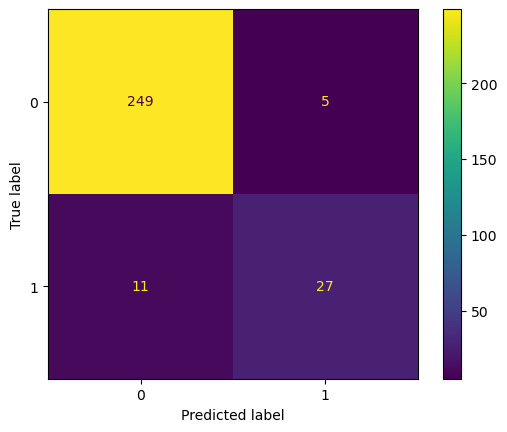

In [13]:
ConfusionMatrixDisplay(confusion_matrix(y_test, search.predict(X_test)),
                       display_labels=search.classes_).plot()

### Performance metrics

In [ ]:
# A functions that helps compare different pipelines and models using the most influental performance metrics
def add_perf_metrics(model, model_name):

    # Create csv file, if it doesnt exist, else read it
    filename = 'data/model_performance.csv'
    if not os.path.exists(filename):
        with open(filename, 'w'): pass
        performance_metrics = pd.DataFrame(columns=["model", "accuracy_train", "accuracy_test", "f1", "cohen"])
    else:
        performance_metrics = pd.read_csv(filename)
  
    # make predictions on test and trained data
    y_pred_search_train = search.predict(X_train)
    y_pred_search_test = search.predict(X_test)

    # check accuracy on the test and trained dataset
    ac_sc_train = accuracy_score(y_true = y_train,
                y_pred = y_pred_search_train
                ).round(3)
    ac_sc_test = accuracy_score(y_true = y_test,
                y_pred = y_pred_search_test
                ).round(3)
    
    # further metrics
    f1 = f1_score(y_test, y_pred_search_test)
    cohen = cohen_kappa_score(y_test, y_pred_search_test)

    # compile new data and add to df
    new_data = pd.DataFrame({"model": model_name, "accuracy_train": ac_sc_train, "accuracy_test": ac_sc_test, "f1": f1, "cohen": cohen}, index=[0])
    performance_metrics = pd.concat([performance_metrics, new_data], ignore_index=True)

    # save to csv
    performance_metrics.to_csv(filename, index = False)

    print(performance_metrics)


In [16]:
add_perf_metrics(search, "Forest_n_est+max_feat+max_depth+split")

                                    model  accuracy_train  accuracy_test  \
0                            Decisiontree           0.961          0.928   
1                                     KNN           0.966          0.921   
2                                  LogReg           0.967          0.942   
3                                 SVC_gen           0.986          0.952   
4                            SVC_gen_noID           0.988          0.942   
5                                SVC_best           0.983          0.928   
6                               SVC_best2           0.985          0.942   
7                               SVC_best3           0.965          0.932   
8                              Forest_gen           1.000          0.949   
9                             Forest_gen2           1.000          0.955   
10                            Forest_best           0.988          0.949   
11                           Forest_best2           0.994          0.942   
12          

# Competition

Run best method and model on a new dataset and submit to group-internal competitions page.  


In [17]:
# Reading test data set
housing_comp = pd.read_csv("data/test.csv")

In [18]:
# Retrieve ID and delete it from the test dataset
housing_ids = housing_comp.pop("Id")

In [19]:
# Predict "Expensive" for competetion data set
y_pred_comp = search.predict(housing_comp)
y_pred_comp

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [20]:
# create df, save to csv and upload
housing_comp_result = pd.DataFrame({"Id" : housing_ids, "Expensive" : y_pred_comp})
housing_comp_result.to_csv("data/housing_competetion_result_7.csv", index=False)